In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

In [10]:
DATA_FOLDER = '../data/'
TRAIN_SAMPLE_FOLDER = 'dfdc_train_part_0'
#TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
#print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 1335


Load the `metadata.json` file.

In [14]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, 'metadata.json'))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

,label,split,original
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
vpmyeepbep.mp4,REAL,train,NaN
fzvpbrzssi.mp4,REAL,train,NaN
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


Check for missing data

In [15]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [17]:
missing_data(meta_train_df)

,label,split,original
Total,0,0,86
Percent,0,0,6.44678
Types,object,object,object


So 86 (6%) of the videos don't have an "Original" link. This is probably because they're the real videos.

In [23]:
# We can double check that there are the same number of REAL videos
print("There are {} real videos".format(len(meta_train_df.loc[meta_train_df['label'] == 'REAL'])))

There are 86 real videos


In [24]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [25]:
unique_values(meta_train_df)

,label,split,original
Total,1334,1334,1248
Uniques,2,1,86


In [26]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [27]:
most_frequent_values(meta_train_df)

,label,split,original
Total,1334,1334,1248
Most frequent item,FAKE,train,fdpisghkmd.mp4
Frequence,1248,1334,36
Percent from total,93.553,100,2.885


In [32]:
# Here are a few examples of the the fake videos for fdpisghkmd.mp4
meta_train_df.loc[meta_train_df['original'] == 'fdpisghkmd.mp4'].head()

,label,split,original
iimnvjpgoy.mp4,FAKE,train,fdpisghkmd.mp4
dabysiasvf.mp4,FAKE,train,fdpisghkmd.mp4
ngnoguzzkd.mp4,FAKE,train,fdpisghkmd.mp4
pkkmysbvfh.mp4,FAKE,train,fdpisghkmd.mp4
rlffjkxsqq.mp4,FAKE,train,fdpisghkmd.mp4


In [33]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes / feature
    param: feature - the feature to analyze
    param: title - title to add to the graph
    param: df - dataframe from which we plot feature's classes distribution 
    param: size - default 1.
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

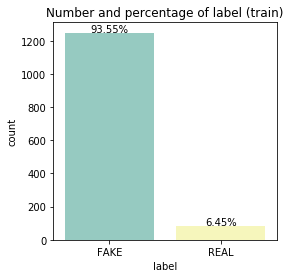

In [34]:
plot_count('label', 'label (train)', meta_train_df)

Fake accounts for 93% of our videos!

In [36]:
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

['iimnvjpgoy.mp4', 'achdeirhym.mp4', 'qrgrezupjj.mp4']

In [37]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)

In [39]:
class ObjectDetector():
    '''
    Class for Object Detection
    '''
    def __init__(self,object_cascade_path):
        '''
        param: object_cascade_path - path for the *.xml defining the parameters for {face, eye, smile, profile}
        detection algorithm
        source of the haarcascade resource is: https://github.com/opencv/opencv/tree/master/data/haarcascades
        '''

        self.objectCascade=cv.CascadeClassifier(object_cascade_path)


    def detect(self, image, scale_factor=1.3,
               min_neighbors=5,
               min_size=(20,20)):
        '''
        Function return rectangle coordinates of object for given image
        param: image - image to process
        param: scale_factor - scale factor used for object detection
        param: min_neighbors - minimum number of parameters considered during object detection
        param: min_size - minimum size of bounding box for object detected
        '''
        rects=self.objectCascade.detectMultiScale(image,
                                                scaleFactor=scale_factor,
                                                minNeighbors=min_neighbors,
                                                minSize=min_size)
        return rects

In [40]:
#Frontal face, profile, eye and smile  haar cascade loaded
frontal_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_frontalface_default.xml')
eye_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_eye.xml')
profile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_profileface.xml')
smile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_smile.xml')

#Detector object created
# frontal face
fd=ObjectDetector(frontal_cascade_path)
# eye
ed=ObjectDetector(eye_cascade_path)
# profile face
pd=ObjectDetector(profile_cascade_path)
# smile
sd=ObjectDetector(smile_cascade_path)

NameError: name 'FACE_DETECTION_FOLDER' is not defined